In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: ______________________
- PRN : ______________________


# Deep Neural Networks

## Session A06 : 
## Working with PyTorch
- Custom DataSet with common transformation
- ${swish}$ activation function
- Regularizations:
    - L2, 
    - BatchNorm,
    - Dropout, 
    - Early Stopping
    
- multi-class output
- FIFA dataset 

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

## Basic Hygiene

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [5]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  11.7
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


## Helper Functions

In [7]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_torch_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with five columns
                First column need to be epoch, 'x' values
    '''
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor=facecolor, alpha=0.5)
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1,y2], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1][y1],
                           loss_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, 
            transform=ax.transAxes, 
            fontsize=fontsize,
            verticalalignment='top', 
            bbox=props)
    
    # Mark arrow at lowest
    offset = (best[y2].max() - best[y2].max())/10
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1][y3],
                           loss_df.iloc[-1][y4]) #text to plot
        
    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, 
            transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    offset = (best[y4].max() - best[y4].max())/10
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y3.capitalize())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Read FIFA 2019 data set

In [8]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [9]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [10]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [11]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [12]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [13]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [14]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [15]:
# splitting in train ans test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
train_df.shape, test_df.shape

((14517, 34), (3630, 34))

In [16]:
# important to reset the indies as we will be fetching by index

train_df = train_df.reset_index(drop=True)
display (train_df.head())

test_df = test_df.reset_index(drop=True)
display(test_df.head())

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,62.0,57.0,51.0,47.0,61.0,42.0,27.0,41.0,59.0,...,63.0,52.0,21.0,16.0,12.0,11.0,7.0,10.0,12.0,11.0
1,3,55.0,42.0,58.0,60.0,62.0,61.0,56.0,52.0,60.0,...,60.0,53.0,29.0,25.0,22.0,7.0,12.0,6.0,9.0,10.0
2,2,56.0,36.0,61.0,51.0,69.0,60.0,52.0,57.0,66.0,...,54.0,50.0,23.0,22.0,27.0,12.0,10.0,9.0,9.0,14.0
3,0,11.0,12.0,35.0,12.0,12.0,22.0,13.0,40.0,20.0,...,20.0,60.0,11.0,10.0,15.0,69.0,70.0,66.0,67.0,73.0
4,2,66.0,44.0,66.0,48.0,70.0,74.0,75.0,62.0,67.0,...,76.0,60.0,40.0,38.0,28.0,14.0,12.0,6.0,12.0,12.0


,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,2,66.0,33.0,72.0,55.0,81.0,69.0,65.0,61.0,79.0,...,57.0,68.0,23.0,26.0,30.0,12.0,14.0,16.0,6.0,10.0
1,2,71.0,43.0,68.0,43.0,72.0,74.0,69.0,70.0,78.0,...,64.0,66.0,39.0,26.0,16.0,14.0,14.0,13.0,6.0,8.0
2,2,67.0,43.0,61.0,49.0,65.0,48.0,35.0,44.0,65.0,...,54.0,47.0,49.0,13.0,19.0,9.0,12.0,15.0,12.0,13.0
3,2,55.0,37.0,69.0,45.0,67.0,50.0,51.0,64.0,62.0,...,53.0,61.0,55.0,61.0,57.0,13.0,7.0,10.0,8.0,12.0
4,1,25.0,82.0,61.0,20.0,51.0,25.0,33.0,63.0,60.0,...,42.0,67.0,77.0,78.0,70.0,15.0,12.0,13.0,14.0,15.0


## Custom DataSet

In [17]:
'''Using Singleton design pattern'''

class GlobalScaler:
    _instance = None
    
    def __init__ (self):
        if GlobalScaler._instance is not None:
            raise Exception ("GlobalScaler class is a singleton.")

        self.scaler = StandardScaler()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScaler()
        return cls._instance

In [18]:
'''
In this code, we define a custom dataset called FifaDS that takes a DataFrame as input. 

'''

class FifaDS(Dataset):
    
    globalScaler = GlobalScaler.get_instance() # private instance variable
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device, # are we using CPU or GPU
                 is_train = True, # Are we training
                 label_col = None # what col contains labels
                ):
        
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.globalScaler.scaler # Using scaler from global scaller
        self.label_col = label_col
        
        if self.is_train:
            self.labels = self.df[label_col].to_numpy()
            X = self.df.drop(label_col, axis = 1)
            self.features = self.scaler.fit_transform(X)
        else:
            self.labels = self.df[label_col]
            X = self.df.drop(label_col, axis = 1)
            self.features = self.scaler.transform(X)
        
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32, device=self.device)
        label = torch.tensor(label, dtype=torch.int64, device=self.device)
        
        return features, label

In [19]:
label_col = 'Position'
train_ds = FifaDS(train_df, is_train = True, label_col = label_col)
test_ds = FifaDS(test_df, is_train = False, label_col = label_col)

In [20]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


## Vanilla Model 

In [21]:
class Model ( nn.Module ):
    
    def __init__ (self, input_dim):
        
        super( Model, self).__init__()
        
        self.layer1 = nn.Linear( input_dim, 18)
        
        self.layer2 = nn.Linear( 18, 4) # four outputs
        
    def forward(self, x):
        
        x = F.silu (  self.layer1 ( x ) ) # Swish Activation
        x = F.softmax (  self.layer2 ( x ) , dim = 1) # Layer 2 activations
    
        return x

In [22]:
model  = Model( train_df.shape[1] -1 ).to(device)

print(model)

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [23]:
list(model.parameters())

[Parameter containing:
 tensor([[ 9.2062e-02, -4.3501e-02, -1.4794e-01,  1.0717e-02,  1.6225e-01,
          -7.7643e-02, -5.6670e-02,  1.3613e-01, -2.4222e-02, -6.6486e-02,
          -3.5062e-02,  6.3746e-03, -1.4182e-01, -4.9749e-02,  1.6879e-01,
          -3.7317e-02,  1.5855e-01, -6.7960e-02, -7.0020e-02, -5.1887e-02,
          -1.5565e-01, -1.0485e-01,  1.0520e-01, -1.3059e-01,  5.9465e-02,
           1.6379e-01, -2.2121e-02,  7.6153e-02,  8.1313e-02, -1.2426e-01,
          -6.7123e-02, -5.4516e-02,  1.6798e-01],
         [-1.5537e-01,  1.0537e-01,  1.6350e-01,  1.3764e-01,  7.4190e-02,
           7.7494e-02, -9.2818e-03,  8.7583e-02,  1.5868e-01, -5.5976e-02,
           1.6820e-01,  2.7665e-02, -1.2210e-01, -1.2494e-01,  6.1399e-02,
          -2.4561e-02, -7.6685e-02,  8.8150e-02, -9.1821e-02, -8.3203e-02,
           3.2539e-02, -3.1431e-02, -1.4688e-01, -5.2295e-02, -6.1178e-02,
          -7.4187e-02,  1.3552e-01, -2.6404e-02, -1.0632e-01,  5.1576e-02,
           2.9993e-02, -1.3

In [24]:
loss_fn = nn.CrossEntropyLoss()


loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []


optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Train the model for multiple epochs
for epoch in range (EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for data in train_loader:
        
        X_train, y_train = data
        
        optimizer.zero_grad()
        
        model.train() # Set the model in training mode
    
        outputs = model(X_train)
        y_pred = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, y_train)
        batch_acc = accuracy_score(y_train.cpu().numpy(), y_pred.cpu().numpy())

        # Back prop
        optimizer.zero_grad()

        batch_loss.backward()

        optimizer.step()
        
        train_loss += batch_loss.item() * X_train.size(0)
        train_acc += batch_acc * X_train.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        model.eval() # evaluation mode
    
        for data in test_loader:
            
            X_test, y_test = data
            
            outputs = model(X_test)
            y_pred = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, y_test)
            batch_acc = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
            
            test_loss += batch_loss.item() * X_test.size(0)
            test_acc += batch_acc* X_test.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    
    n_epoch.append(epoch)
    
    print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')
    

At epoch 0 | Loss - train:1.0224, test:0.9213 | Acc - train:0.7750, test:0.8309
At epoch 1 | Loss - train:0.8975, test:0.8931 | Acc - train:0.8524, test:0.8515
At epoch 2 | Loss - train:0.8813, test:0.8854 | Acc - train:0.8657, test:0.8592
At epoch 3 | Loss - train:0.8755, test:0.8797 | Acc - train:0.8712, test:0.8636
At epoch 4 | Loss - train:0.8718, test:0.8785 | Acc - train:0.8752, test:0.8645
At epoch 5 | Loss - train:0.8694, test:0.8819 | Acc - train:0.8761, test:0.8587
At epoch 6 | Loss - train:0.8674, test:0.8732 | Acc - train:0.8767, test:0.8700
At epoch 7 | Loss - train:0.8659, test:0.8761 | Acc - train:0.8782, test:0.8661
At epoch 8 | Loss - train:0.8648, test:0.8716 | Acc - train:0.8797, test:0.8702
At epoch 9 | Loss - train:0.8635, test:0.8727 | Acc - train:0.8815, test:0.8675
At epoch 10 | Loss - train:0.8631, test:0.8713 | Acc - train:0.8811, test:0.8713
At epoch 11 | Loss - train:0.8619, test:0.8699 | Acc - train:0.8823, test:0.8713
At epoch 12 | Loss - train:0.8612, tes

In [25]:
loss_df = pd.DataFrame({'epoch'     : n_epoch,
                        'loss'      : loss,
                        'test_loss' : tloss,
                        'acc'       : acc,
                        'test_acc'  : tacc})

In [26]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
26,26,0.855739,0.863802,0.888338,0.87989


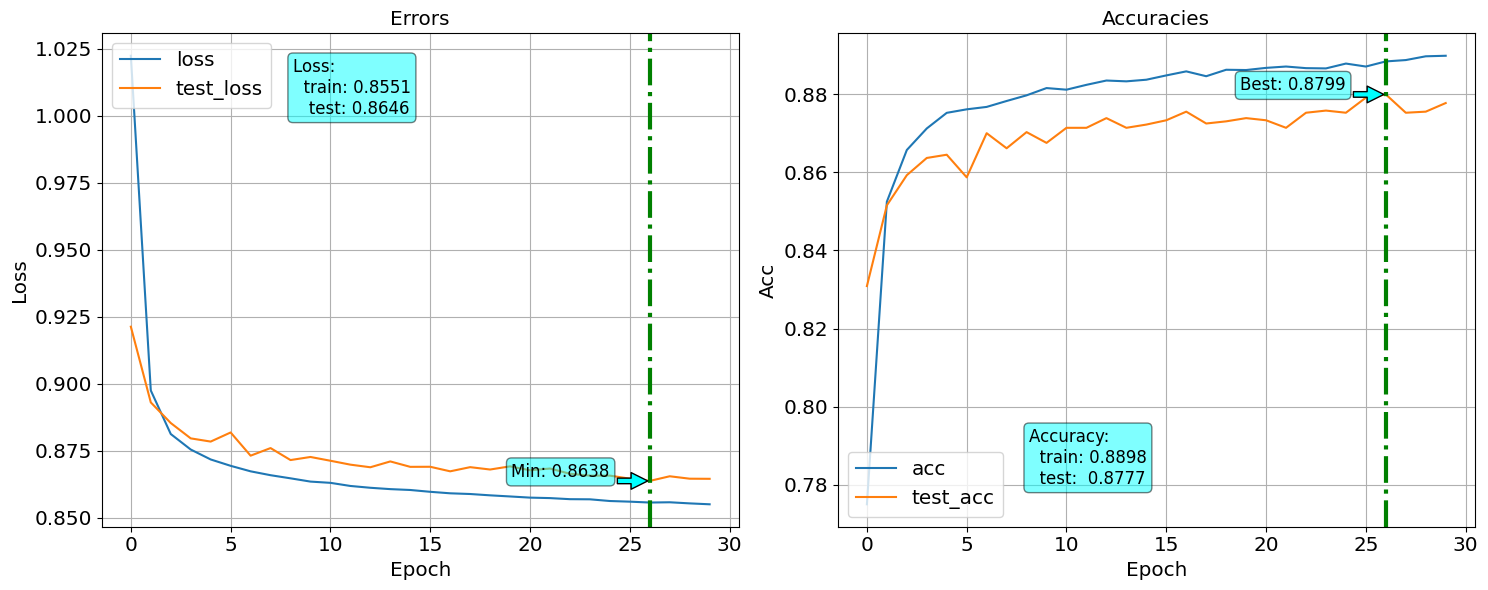

In [27]:
plot_torch_hist(loss_df)

## Accuracies

In [28]:
###-------------
### Train dataset
###-------------

# get input data
X_train, y_train = train_ds[:]

# make predictions
pred_out = model(X_train)
_, y_pred = torch.max(pred_out, 1) # max along an axis gives both max val as well as index

# move over to cpu
y_train = y_train.cpu()
y_pred = y_pred.data.cpu()


print ('Training accuracy : {:.4f}'.format(accuracy_score(y_train, y_pred)))

Training accuracy : 0.8887


In [29]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.92      0.93      4693
           2       0.83      0.89      0.86      5470
           3       0.87      0.77      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.89      0.90     14517
weighted avg       0.89      0.89      0.89     14517



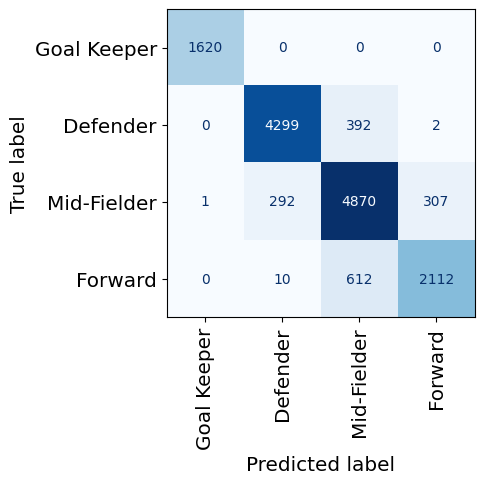

In [30]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [31]:
###-------------
### Test dataset
###-------------

# get input data
X_test, y_test = test_ds[:]

# make predictions
pred_out = model(X_test)
_, y_pred = torch.max(pred_out, 1) # max along an axis gives both max val as well as index

# move over to cpu
y_test = y_test.cpu()
y_pred = y_pred.data.cpu()


print ('Test accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred)))

Test accuracy : 0.8777


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.94      0.90      0.92      1173
           2       0.81      0.89      0.85      1368
           3       0.85      0.74      0.79       684

    accuracy                           0.88      3630
   macro avg       0.90      0.88      0.89      3630
weighted avg       0.88      0.88      0.88      3630



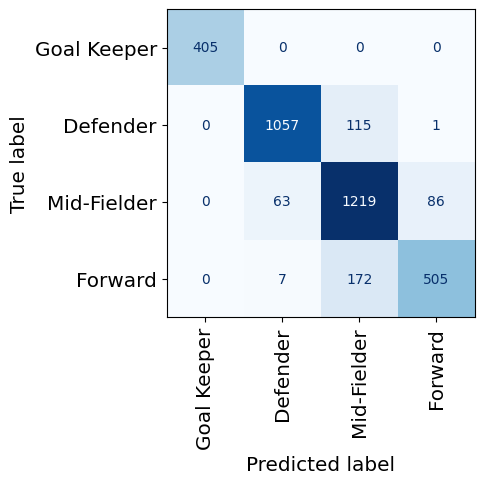

In [33]:
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

## Applying Regularizations

In [34]:
class Model1 ( nn.Module ):
    
    def __init__ (self, input_dim):
        
        super( Model1, self).__init__()
        
        self.layer1 = nn.Linear( input_dim, 18)
        
        self.bn1 = nn.BatchNorm1d(18) # Batch Norm Layer
        
        self.dropout = nn.Dropout(0.1) # Dropout Layer
        
        self.layer2 = nn.Linear( 18, 4) # four outputs
        
    def forward(self, x):
        x = self.bn1( self.layer1 ( x ) ) # use Batch Norm
        
        x = F.silu (x) # Swish Activation
        
        x = self.dropout(x) # we can use dropout too
        
        x = F.softmax (  self.layer2 ( x ) , dim = 1) # Layer 2 activations
    
        return x

In [35]:
model1 = Model1(train_df.shape[1]  - 1).to(device)
print(model1)

Model1(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [36]:
loss_fn = nn.CrossEntropyLoss()


loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(model1.parameters(),
                             lr = ALPHA, 
                             #weight_decay=1e-5 # Regularization
                            )


# Train the model for multiple epochs
for epoch in range (EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        X_train, y_train = data
        
        optimizer.zero_grad()
        
        model1.train() # Set the model in training mode
    
        outputs = model1(X_train)
        y_pred = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, y_train)
        batch_acc = accuracy_score(y_train.cpu().numpy(), y_pred.cpu().numpy())

        # Back prop
        optimizer.zero_grad()

        batch_loss.backward()

        optimizer.step()
        
        train_loss += batch_loss.item() * X_train.size(0)
        train_acc += batch_acc * X_train.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        model1.eval() # evaluation mode
    
        for data in test_loader:
            
            X_test, y_test = data
            
            outputs = model1(X_test)
            y_pred = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, y_test)
            batch_acc = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
            
            test_loss += batch_loss.item() * X_test.size(0)
            test_acc += batch_acc* X_test.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    
    n_epoch.append(epoch)
    
    print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')
    

At epoch 0 | Loss - train:1.0310, test:0.9073 | Acc - train:0.7949, test:0.8545
At epoch 1 | Loss - train:0.9029, test:0.8875 | Acc - train:0.8538, test:0.8584
At epoch 2 | Loss - train:0.8939, test:0.8834 | Acc - train:0.8569, test:0.8612
At epoch 3 | Loss - train:0.8864, test:0.8784 | Acc - train:0.8589, test:0.8664
At epoch 4 | Loss - train:0.8856, test:0.8776 | Acc - train:0.8588, test:0.8656
At epoch 5 | Loss - train:0.8829, test:0.8787 | Acc - train:0.8618, test:0.8628
At epoch 6 | Loss - train:0.8800, test:0.8781 | Acc - train:0.8643, test:0.8642
At epoch 7 | Loss - train:0.8818, test:0.8745 | Acc - train:0.8618, test:0.8672
At epoch 8 | Loss - train:0.8779, test:0.8714 | Acc - train:0.8663, test:0.8738
At epoch 9 | Loss - train:0.8788, test:0.8714 | Acc - train:0.8669, test:0.8708
At epoch 10 | Loss - train:0.8770, test:0.8709 | Acc - train:0.8650, test:0.8713
At epoch 11 | Loss - train:0.8753, test:0.8748 | Acc - train:0.8675, test:0.8675
At epoch 12 | Loss - train:0.8756, tes

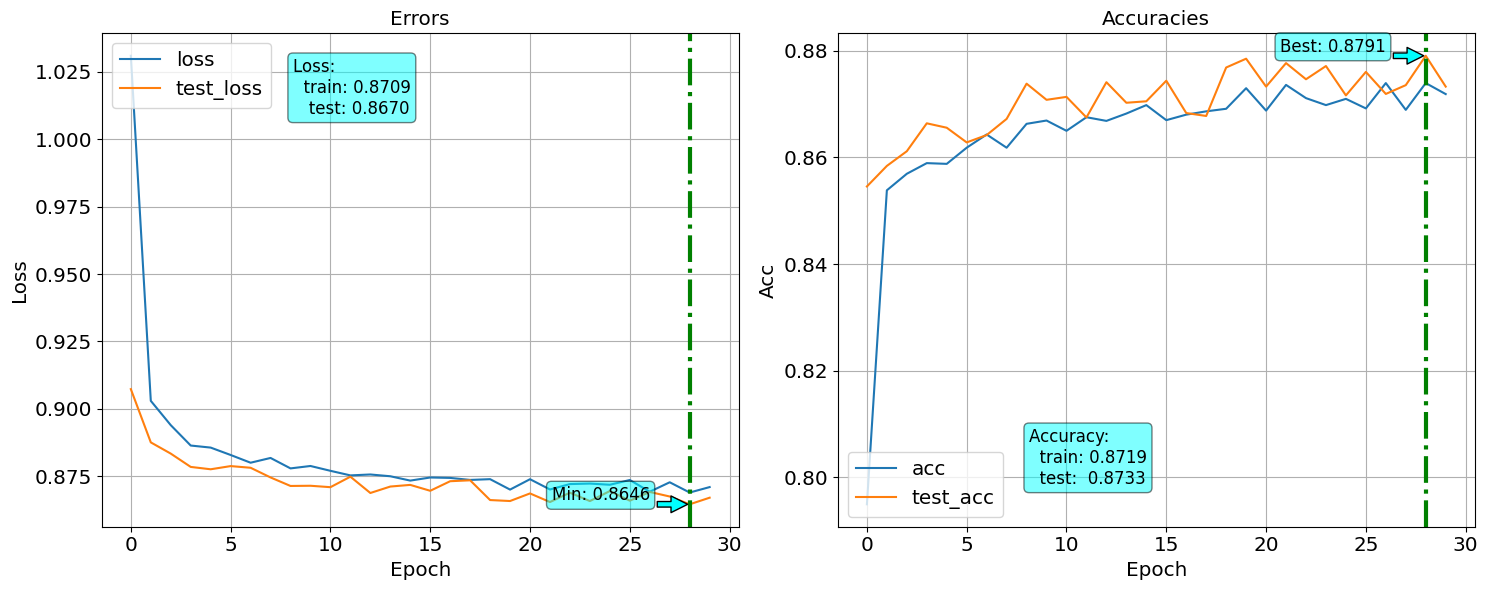

In [37]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

plot_torch_hist(loss_df)

## Accuracies

In [38]:
###-------------
### Train dataset
###-------------

# get input data
X_train, y_train = train_ds[:]

# make predictions
pred_out = model1(X_train)
_, y_pred = torch.max(pred_out, 1) # max along an axis gives both max val as well as index

# move over to cpu
y_train = y_train.cpu()
y_pred = y_pred.data.cpu()


print ('Training accuracy : {:.4f}'.format(accuracy_score(y_train, y_pred)))

Training accuracy : 0.8871


In [39]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.92      0.92      4693
           2       0.84      0.87      0.85      5470
           3       0.85      0.79      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.90      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



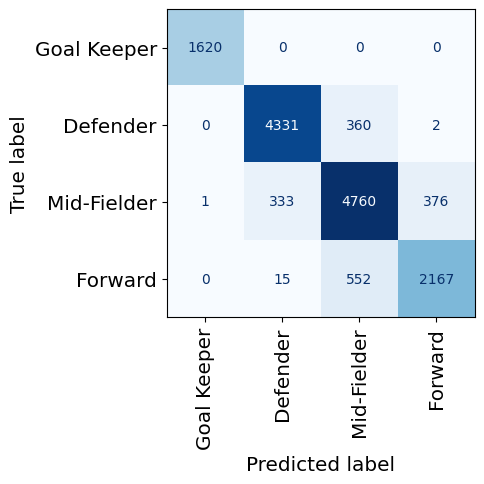

In [40]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [41]:
###-------------
### Test dataset
###-------------

# get input data
X_test, y_test = test_ds[:]

# make predictions
pred_out = model1(X_test)
_, y_pred = torch.max(pred_out, 1) # max along an axis gives both max val as well as index

# move over to cpu
y_test = y_test.cpu()
y_pred = y_pred.data.cpu()


print ('Test accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred)))

Test accuracy : 0.8733


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.93      0.91      0.92      1173
           2       0.82      0.86      0.84      1368
           3       0.82      0.75      0.78       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.87      0.87      0.87      3630



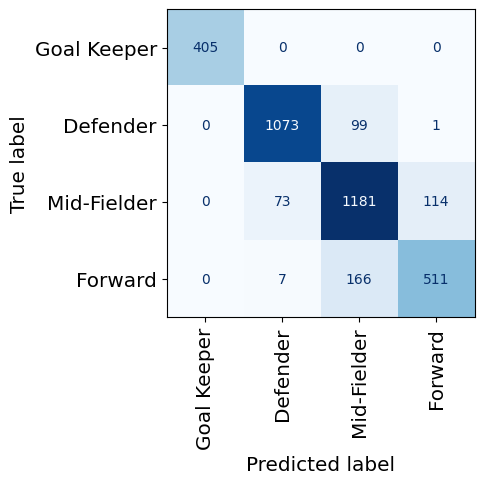

In [43]:
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

# Assignment: A06

1. Optimize accuracy using different combination of regularization
2. Implement Early Stopping 
3. Change data set to Fashion MNIST 